# Monthly Active User Depth of Engagement (CDFs)

For each user active in a month, how many days of the month are they using it?

For a full writeup, see the blog post at: http://www.danwolch.com/2017/12/mau-depth-of-engagement-cdf/

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# you only need this if you're connecting to your database directly
from sqlalchemy import create_engine

import pandas as pd

DB_USERNAME = "fill your db username in here"
DB_PASSWORD = "fill your db password in here"

# sample: "hostname.us-east-1.redshift.amazonaws.com:5439/database_name"
DB_CONN_STR = "fill in your host, port, db name here"

LOAD_FROM_FILE = True

In [3]:
mau_cdf_sql = """
    WITH daily_user_table AS (
        SELECT
            DISTINCT user_id
            , DATE_TRUNC('day', event_time) as dt
        FROM events
        WHERE event_time BETWEEN '2017-12-01 00:00:00' AND '2017-12-31 23:59:59' 
    ), user_day_count AS (
        SELECT user_id
            , COUNT(DISTINCT DATE_TRUNC('day', dt)) as day_count
        FROM daily_user_table
        GROUP BY user_id
    )
    SELECT day_count, COUNT(DISTINCT user_id) as user_count
    FROM user_day_count
    GROUP BY 1
    ORDER BY day_count
"""

In [9]:
if LOAD_FROM_FILE:
  df = pd.read_csv("sample.csv", names=["day_count", "user_count"], index_col='day_count')
else:
  conn_str = "postgresql://%s:%s@%s" % (DB_USERNAME, DB_PASSWORD, DB_CONN_STR)
  engine = create_engine(conn_str)
  cmd_sql = mau_cdf_sql
  df = pd.read_sql_query(cmd_sql, engine)

In [16]:
total_users = df['user_count'].sum()
df['cumulative_users'] = df['user_count'].cumsum()
df['cumulative_users_pct'] = 100 * df['cumulative_users'] / total_users

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11638e590>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x116e16490>], dtype=object)

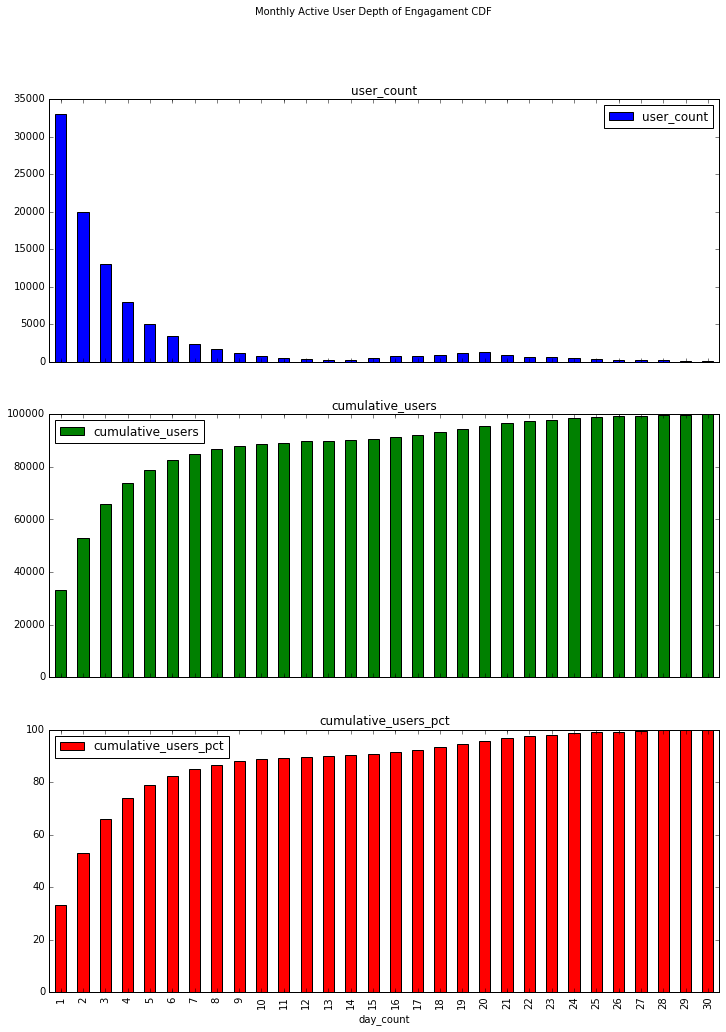

In [20]:
df.plot(subplots=True, figsize=(12,16), 
            title="Monthly Active User Depth of Engagament CDF", kind='bar')